In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
import math
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#KDE Portion

#Reading the csv data
csv_file = "Final_Fire_Incidence_Data_with_PopDensity.csv"
df = pd.read_csv(csv_file)

#Reading Building Risk Data
csv_file_br = "building_fire_risk.csv"
df_bfr = pd.read_csv(csv_file_br)
df_bfr['zipcode']=df_bfr['zipcode'].astype(float)
df_bfr=df_bfr.rename(columns={'area_mile2':'building_risk'})

#Merging fire incidence data with building risk data
df=pd.merge(df,df_bfr[['zipcode','building_risk']],left_on='MODZCTA',right_on='zipcode',how='left')


#KDE data preparation
df["geometry"] = df["the_geom"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf = gdf.dropna(subset=["geometry"])
gdf = gdf[gdf.geometry.is_valid]

gdf["high_risk_count"] = gdf["high_risk_count"].fillna(0)
gdf["medium_risk_count"] = gdf["medium_risk_count"].fillna(0)
gdf["low_risk_count"] = gdf["low_risk_count"].fillna(0)
gdf["area_mile2"] = gdf["area_mile2"].fillna(0)
gdf["pop_density_per_sqmi"] = gdf["pop_density_per_sqmi"].fillna(0)

gdf["weight"] = ((
    3*gdf["high_risk_count"]
  + 2*gdf["medium_risk_count"]
  + 1*gdf["low_risk_count"])
  *   gdf["pop_density_per_sqmi"]* gdf["building_risk"]
)

gdf_3857 = gdf.to_crs(epsg=3857)
gdf_3857["centroid"] = gdf_3857.geometry.centroid

cx = gdf_3857["centroid"].x.values
cy = gdf_3857["centroid"].y.values
weights = gdf_3857["weight"].values

buffer_m = 100
xmin, ymin, xmax, ymax = gdf_3857.total_bounds
xmin -= buffer_m
ymin -= buffer_m
xmax += buffer_m
ymax += buffer_m

num_x = 300
num_y = 300
xs = np.linspace(xmin, xmax, num_x)
ys = np.linspace(ymin, ymax, num_y)
X, Y = np.meshgrid(xs, ys)
def epanechnikov_2d(distance, h):
    mask = distance < h
    c = 2.0 / (math.pi * h**2)
    out = np.zeros_like(distance, dtype=float)
    out[mask] = c * (1.0 - (distance[mask]**2 / h**2))
    return out

bandwidth = 2500.0

X3 = X[..., None]
Y3 = Y[..., None]
cx_ = cx[None, :]
cy_ = cy[None, :]
#dist = np.sqrt((X3 - cx)**2 + (Y3 - cy)**2)
dist = np.sqrt((X3 - cx_)**2 + (Y3 - cy_)**2)
Kvals = epanechnikov_2d(dist, bandwidth)

weighted = Kvals * weights
density = weighted.sum(axis=2)


In [3]:
#Generating CSV file containing the zipcode KDE values

points_list = []
dens_list = []

for i in range(num_y):
    for j in range(num_x):
        xcoord = xs[j]
        ycoord = ys[i]
        points_list.append(Point(xcoord, ycoord))
        dens_list.append(density[i, j])

gdf_points = gpd.GeoDataFrame(
    {"density": dens_list},
    geometry=points_list,
    crs="EPSG:3857"
)

joined = gpd.sjoin(
    gdf_points,
    gdf_3857,
    how="left",
    predicate="within"
)

grouped = joined.groupby("MODZCTA")["density"]

mean_density_by_zip = grouped.mean()

val_min = mean_density_by_zip.min()
val_max = mean_density_by_zip.max()
range_ = val_max - val_min

scaled = 100 * (mean_density_by_zip - val_min) / range_

df_zip_density = pd.DataFrame({
    "MODZCTA": mean_density_by_zip.index,
    "mean_kde": mean_density_by_zip.values,
    "scaled_kde_0_100": scaled.values
})

df_zip_density.sort_values("mean_kde", ascending=False, inplace=True)

output_csv = "kde_by_zipcode.csv"
df_zip_density.to_csv(output_csv, index=False)

print(f"Exported KDE by ZIP code to '{output_csv}'. Top rows:")
print(df_zip_density.head(16))

Exported KDE by ZIP code to 'kde_by_zipcode.csv'. Top rows:
     MODZCTA     mean_kde  scaled_kde_0_100
61   10456.0  1320.145513        100.000000
25   10029.0  1206.848407         91.416182
22   10026.0  1195.894477         90.586271
62   10457.0  1168.991323         88.547986
57   10452.0   996.742254         75.497744
63   10458.0   980.135105         74.239524
58   10453.0   972.225530         73.640264
73   10468.0   907.443645         68.732144
93   11206.0   884.400775         66.986328
119  11233.0   876.967357         66.423145
99   11212.0   851.800789         64.516430
108  11221.0   811.716221         61.479471
56   10451.0   809.040168         61.276724
21   10025.0   805.908439         61.039452
64   10459.0   761.020098         57.638541
41   10128.0   744.589338         56.393685


In [4]:
df=pd.read_csv("pluto_25v1.csv")
vacant_land=df[df['landuse']==11]
vacant_land['geometry']=vacant_land.apply(lambda row: Point(row['longitude'],row['latitude']),axis=1)
gdf_vacant=gpd.GeoDataFrame(vacant_land,geometry='geometry',crs="EPSG:4326")

vacant_land_3857=gdf_vacant.to_crs(epsg=3857)


#Filtering rows in the dataframe that are within the top 10 zipcodes

zip_list=list(df_zip_density['MODZCTA'].head(16))
#zip_list=[10456.0,10029.0,10026.0,10457.0,10452.0,10458.0,10453.0,10468.0,11206.0,11233.0,11212.0,11221.0,10451.0,10025.0,10459.0,10128.0]

#Filtering top 10 zipcodes
filtered_df = vacant_land_3857[vacant_land_3857['zipcode'].isin(zip_list)]

#Filtering lots with areas greater than 5642
filtered_df = filtered_df[filtered_df['lotarea']>5642]

C:\Users\harsh\AppData\Local\Temp\ipykernel_42232\3397575301.py:1: DtypeWarning: Columns (21,22,24,25,26,28,65,66,81,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("pluto_25v1.csv")
C:\Users\harsh\AppData\Local\Temp\ipykernel_42232\3397575301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vacant_land['geometry']=vacant_land.apply(lambda row: Point(row['longitude'],row['latitude']),axis=1)


In [5]:

#Data to use in K-Medoids
X=filtered_df[['latitude','longitude']]

#Rows that have na values in any of the columns
rows_na=X[X.isna().any(axis=1)]

#Dropping rows that have na's in any of the columns in the dataframe
X.dropna(inplace=True)

#K-Medoids Model

from sklearn_extra.cluster import KMedoids
kmedoids=KMedoids(n_clusters=15, init='random', metric='euclidean', random_state=4)
kmedoids.fit(X)

#Medoids and their labels:
medoid_indices=kmedoids.medoid_indices_
cluster_centers=kmedoids.cluster_centers_

#Indices of the cluster centers in the original dataset
originalindices= X.index
rows_required=[originalindices[i] for i in medoid_indices]

#Required points
filtered_df=filtered_df.loc[rows_required]
filtered_df.to_csv('Potential_location.csv', index=False)

C:\Users\harsh\AppData\Local\Temp\ipykernel_42232\1796351137.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


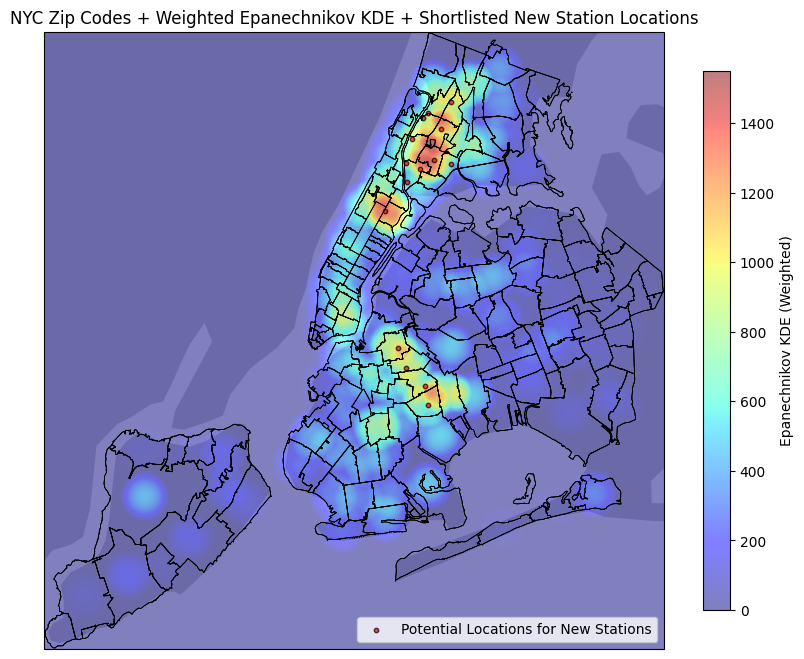

In [33]:
#Visulatization of the shortlisted station on KDE plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))

ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="lightgray")
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.5)
#ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.5)
#ax.add_feature(cfeature.OCEAN,facecolor="lightblue", linewidth=0.5)

zip_polygons = ShapelyFeature(
    gdf_3857["geometry"],
    ccrs.epsg(3857),
    edgecolor="black",
    facecolor="none",
    linewidth=0.5
)

ax.add_feature(zip_polygons)

#Identifying locations for potential fire stations
ax.scatter(filtered_df.geometry.x, filtered_df.geometry.y, 
           color='red', s=10, edgecolor='black', alpha=0.7, 
           transform=ccrs.epsg(3857), label="Potential Locations for New Stations")


im = ax.imshow(
    density,
    origin="lower",
    extent=[xmin, xmax, ymin, ymax],
    alpha=0.5,
    cmap="jet",
    transform=ccrs.epsg(3857)
)

cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Epanechnikov KDE (Weighted)")

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.epsg(3857))
ax.legend(loc="lower right", bbox_to_anchor=(1,0),fontsize=10)
plt.title("NYC Zip Codes + Weighted Epanechnikov KDE + Shortlisted New Station Locations")
plt.show()


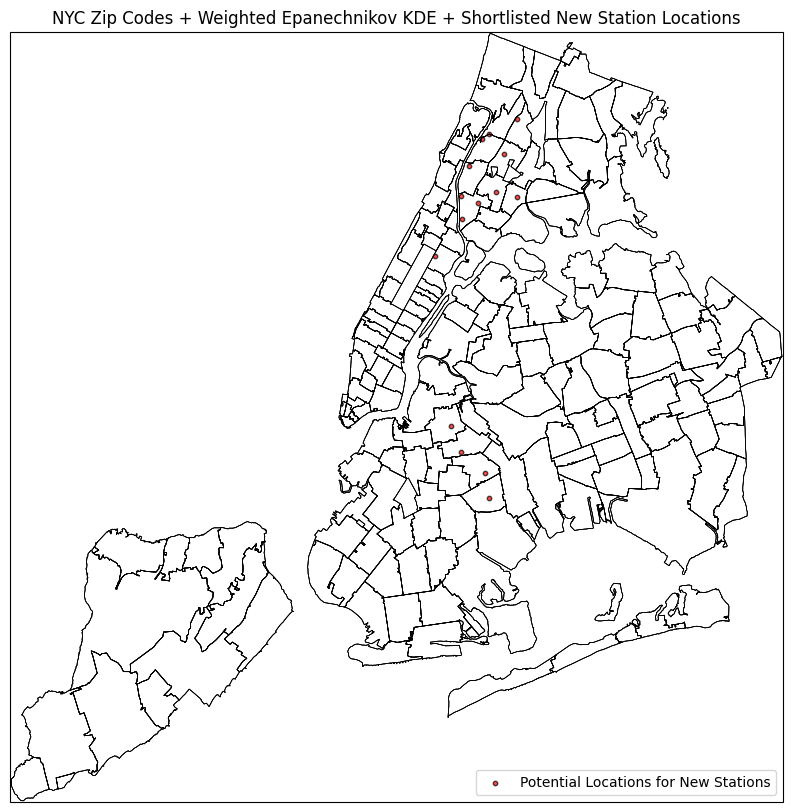

In [31]:
#Visulatization of the shortlisted station on NYC area

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))

#ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="lightgray")
#ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.5)
#ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.5)


zip_polygons = ShapelyFeature(
    gdf_3857["geometry"],
    ccrs.epsg(3857),
    edgecolor="black",
    facecolor="none",
    linewidth=0.5
)

ax.add_feature(zip_polygons)

#Identifying locations for potential fire stations
ax.scatter(filtered_df.geometry.x, filtered_df.geometry.y, 
           color='red', s=10, edgecolor='black', alpha=0.7, 
           transform=ccrs.epsg(3857), label="Potential Locations for New Stations")


#cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.7)
#cbar.set_label("Epanechnikov KDE (Weighted)")

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.epsg(3857))
ax.legend(loc="lower right", bbox_to_anchor=(1,0),fontsize=10)
plt.title("NYC Zip Codes + Weighted Epanechnikov KDE + Shortlisted New Station Locations")
plt.show()
